In [1]:
from numpy.random import seed
seed(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis import *
from collections import namedtuple
import Metrics
from PatientSet import *
from Constants import Constants
from Clustering import *
import re

#sklearn dependencies
from sklearn.metrics import roc_auc_score, adjusted_rand_score
from sklearn.utils import resample
from sklearn.cluster import FeatureAgglomeration

#we get like a million deprication errors for some reason with the external libraries
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
#plotting parameter
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
FIG_SIZE = (20,15)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=FIG_SIZE)
db = load_patientset()

In [20]:
#parameters for the experiments
toxicities_to_test = ['toxicity']

save_root = 'data/sensitivity_analysis/'

#features to test the feature selection on.  should be fields in the patientset we have
#we don't cluster on these
unclusterable_features = ['t_volumes', 'bilateral', 'total_volumes','neck_width']
#we cluster on these (each individually) if feature_clustering is defined,
clusterable_features = ['tumor_distances', 'volumes']

#features specifically for feature selection vs actually using.  Should either be
#some combo of actual and predicted dose for this
true_features = ['doses']
predicted_features = ['tsimdoses']

#number of times to resample and doing feature selection
#if n = 1, just use the first result
n_samples = 500

#function to normalize the variables before clusterings
df_rescale = Metrics.normalize

#for now just constrain it to one cluster
n_clusters = 4
selection_clusterer  = BestClusterer()
cluster_feature_selector = FeatureClusterSelector(
    n_samples = n_samples,
    model = selection_clusterer)
lg_feature_selector = FeatureSelector(n_samples = n_samples)

In [21]:
true, predicted = get_train_test_datasets(db, 
                                      unclusterable_features, 
                                      clusterable_features, 
                                      true_features, 
                                      predicted_features)
if df_rescale is not None:
    true = df_rescale(true)
    predicted = df_rescale(predicted)

In [22]:
cluster_importances = cluster_feature_selector.get_importances(predicted, db.toxicity, as_df = True)
cluster_importances.to_csv(save_root + 'cluster_importances.csv')
cluster_importances.describe()

,Esophagus_tsimdoses,Spinal_Cord_tsimdoses,Cricopharyngeal_Muscle_tsimdoses,Cricoid_cartilage_tsimdoses,IPC_tsimdoses,MPC_tsimdoses,Brainstem_tsimdoses,Larynx_tsimdoses,Thyroid_cartilage_tsimdoses,Supraglottic_Larynx_tsimdoses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.976268,0.994106,0.996986,0.996997,0.993303,0.994364,0.989938,0.997127,0.996958,0.994025,...,0.884533,7.273931e-01,0.969902,0.769627,0.868092,0.980154,0.869141,0.983471,0.914442,0.967535
std,0.064194,0.036453,0.016065,0.012241,0.029262,0.040648,0.042800,0.016723,0.023524,0.030114,...,0.174463,2.475637e-01,0.072116,0.250541,0.185748,0.049848,0.199565,0.045931,0.142806,0.074905
min,0.391582,0.256386,0.757587,0.842489,0.603452,0.184488,0.497796,0.738602,0.565972,0.585557,...,0.043373,1.033618e-13,0.256739,0.000000,0.065464,0.519838,0.000000,0.485138,0.132076,0.570877
25%,0.985274,0.998719,0.999803,0.999419,0.998579,0.998999,0.997934,0.999717,0.999795,0.999420,...,0.858697,5.750276e-01,0.978725,0.672467,0.816009,0.984227,0.826965,0.989328,0.893680,0.978645
50%,0.998522,0.999932,0.999993,0.999969,0.999922,0.999951,0.999841,0.999984,0.999991,0.999972,...,0.956221,7.895692e-01,0.996150,0.845000,0.956237,0.998218,0.963711,0.998585,0.979687,0.997194
75%,0.999935,0.999998,1.000000,0.999998,0.999996,0.999998,0.999994,1.000000,1.000000,0.999999,...,0.988925,9.352128e-01,0.999635,0.965250,0.994194,0.999812,0.994970,0.999880,0.996714,0.999790
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999999,9.999668e-01,1.000000,0.999979,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
lg_importances = lg_feature_selector.get_importances(predicted, db.toxicity, as_df = True)
lg_importances.to_csv(save_root + 'lg_importances.csv')
lg_importances.describe()

,Esophagus_tsimdoses,Spinal_Cord_tsimdoses,Cricopharyngeal_Muscle_tsimdoses,Cricoid_cartilage_tsimdoses,IPC_tsimdoses,MPC_tsimdoses,Brainstem_tsimdoses,Larynx_tsimdoses,Thyroid_cartilage_tsimdoses,Supraglottic_Larynx_tsimdoses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.612830,0.697687,0.713561,0.708773,0.625198,0.723692,0.685260,0.668780,0.671266,0.654115,...,0.509673,0.445804,0.626476,0.285017,0.556081,0.607819,0.539839,0.667044,0.353300,0.598126
std,0.084908,0.061564,0.057758,0.059564,0.081245,0.055862,0.058758,0.063396,0.064565,0.066326,...,0.121209,0.148582,0.080347,0.150904,0.116182,0.072413,0.097357,0.063122,0.207180,0.151766
min,0.001768,0.446841,0.429128,0.464741,0.000000,0.477011,0.468994,0.436340,0.353312,0.356322,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.570896,0.661323,0.678436,0.669070,0.580238,0.689590,0.649967,0.629570,0.630377,0.612782,...,0.477189,0.410558,0.592177,0.174695,0.523659,0.575391,0.502212,0.633935,0.185221,0.583674
50%,0.620593,0.702320,0.715542,0.712989,0.632698,0.722561,0.688556,0.669104,0.674113,0.659766,...,0.530556,0.483693,0.637925,0.271256,0.571886,0.615413,0.555146,0.672718,0.340542,0.640429
75%,0.660987,0.739206,0.753581,0.745269,0.678633,0.764396,0.723917,0.714455,0.714202,0.698385,...,0.582195,0.542244,0.676856,0.403538,0.625193,0.650959,0.596419,0.706581,0.555500,0.682683
max,0.792457,0.864243,0.889391,0.884117,0.835490,0.880823,0.835795,0.864225,0.847348,0.854204,...,0.733506,0.663414,0.786320,0.671329,0.752835,0.770459,0.710216,0.800249,0.728574,0.826863


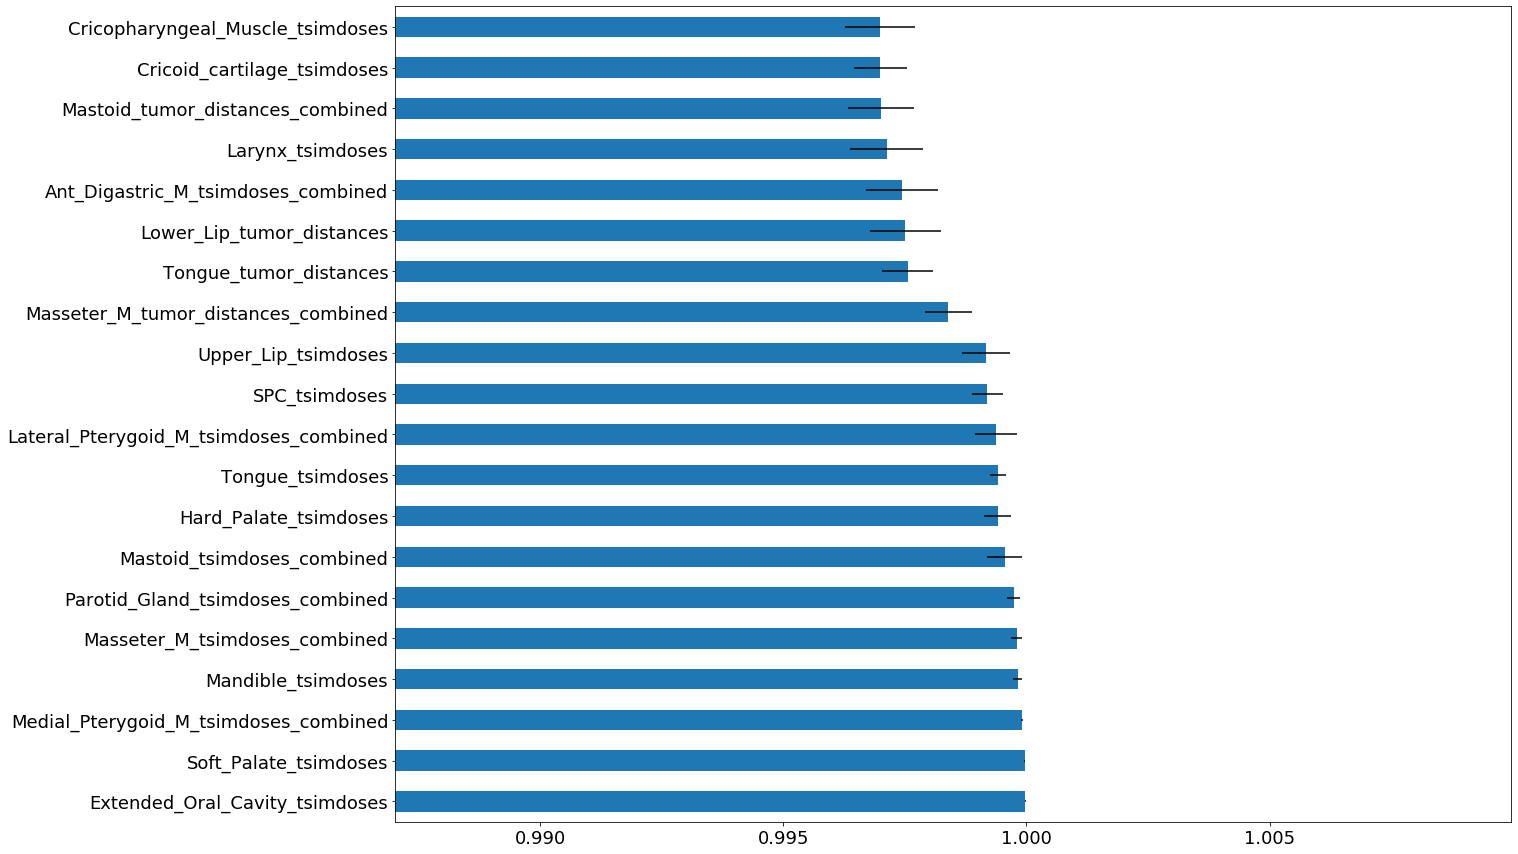

In [23]:
top_n_importances = lambda x, n: x.mean().sort_values(ascending = False).iloc[0:n]
def plot_n_importances(x, n):
    x = x.reindex(x.mean().sort_values(ascending=False).index, axis = 'columns')
    x = x.iloc[:,0:n]
    xrange = [x.mean().values.min()*.99, x.mean().values.max()*1.01]
    x.mean().plot.barh(**{'xerr': x.std().values/np.sqrt(n_samples), 'xlim': xrange})
plot_n_importances(cluster_importances, 20)

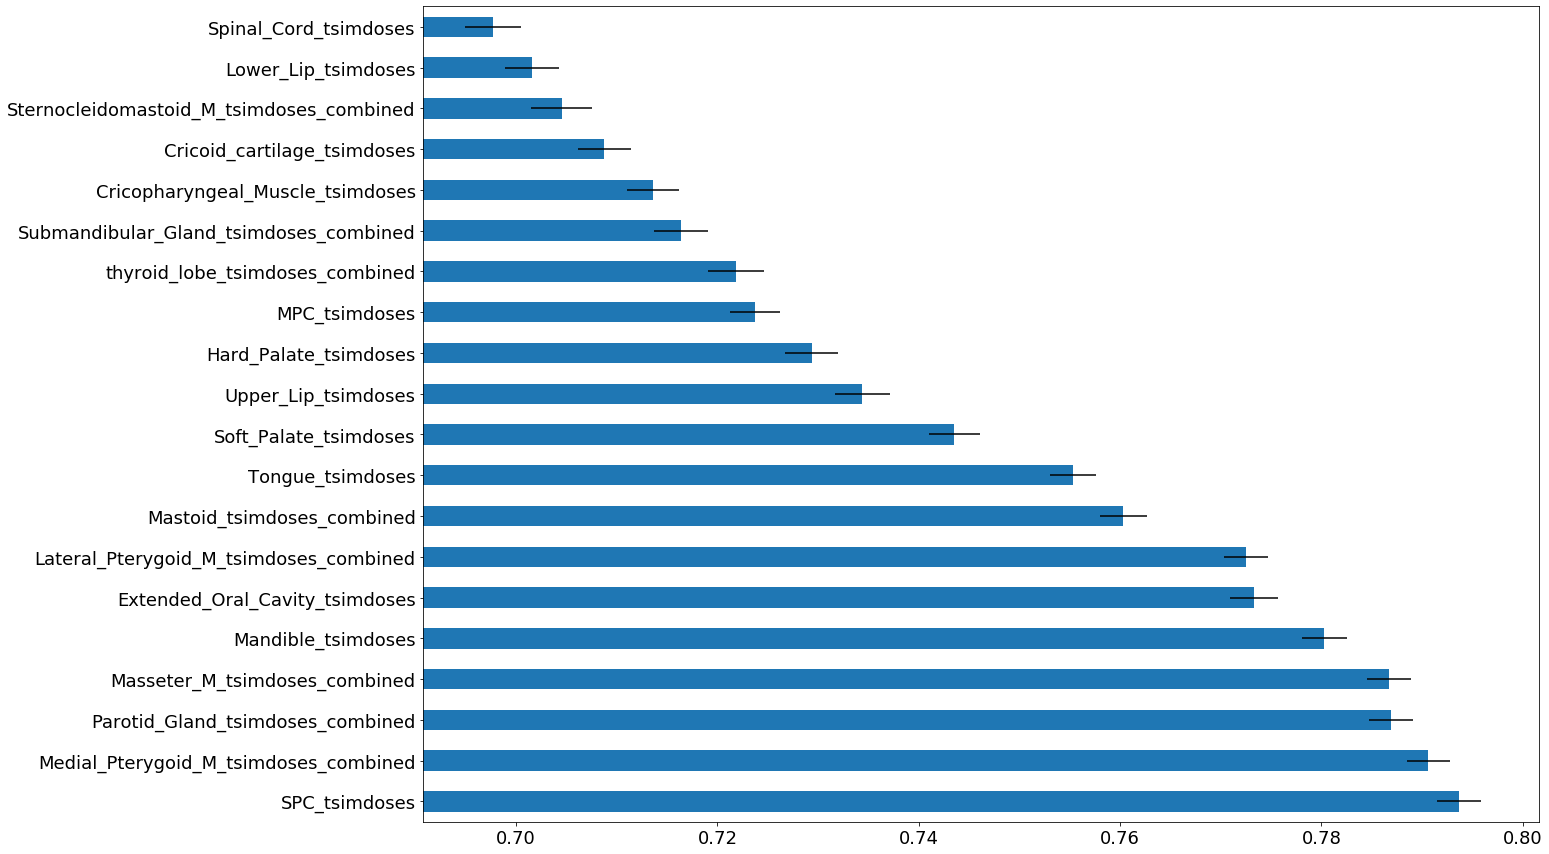

In [8]:
plot_n_importances(lg_importances,20)

In [24]:
true_cluster_importances = cluster_feature_selector.get_importances(true, db.toxicity, as_df = True)
true_cluster_importances.describe()
true_cluster_importances.to_csv(save_root + 'truedose_cluster_importances.csv')

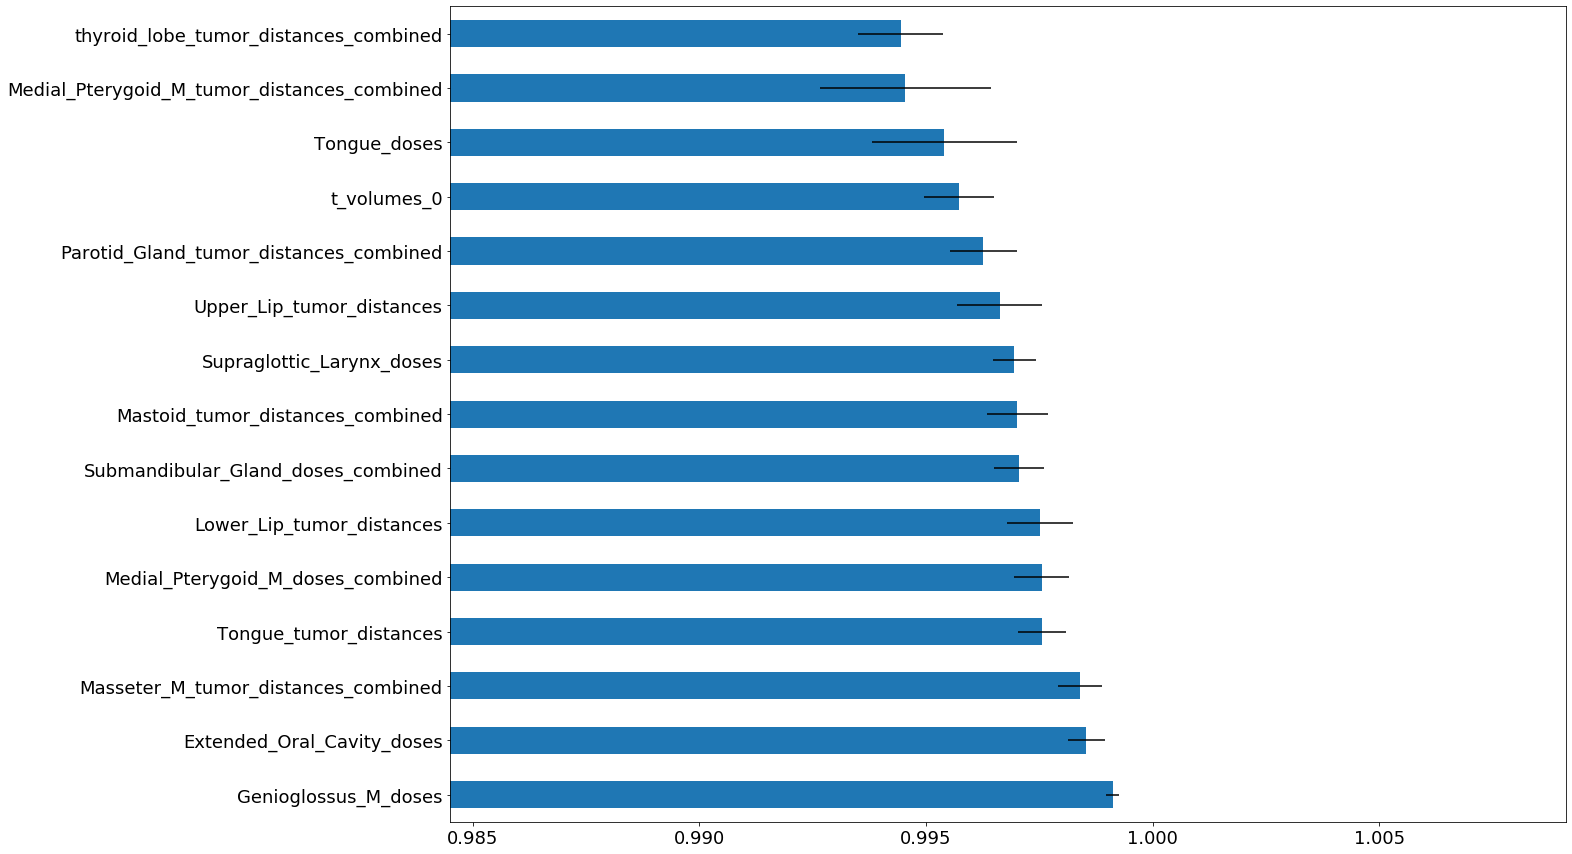

In [25]:
plot_n_importances(true_cluster_importances, 15)

In [11]:
true_lg_importances = lg_feature_selector.get_importances(true, db.toxicity, as_df = True)
true_lg_importances.describe()
true_lg_importances.to_csv(save_root + 'truedose_cluster_importances.csv')

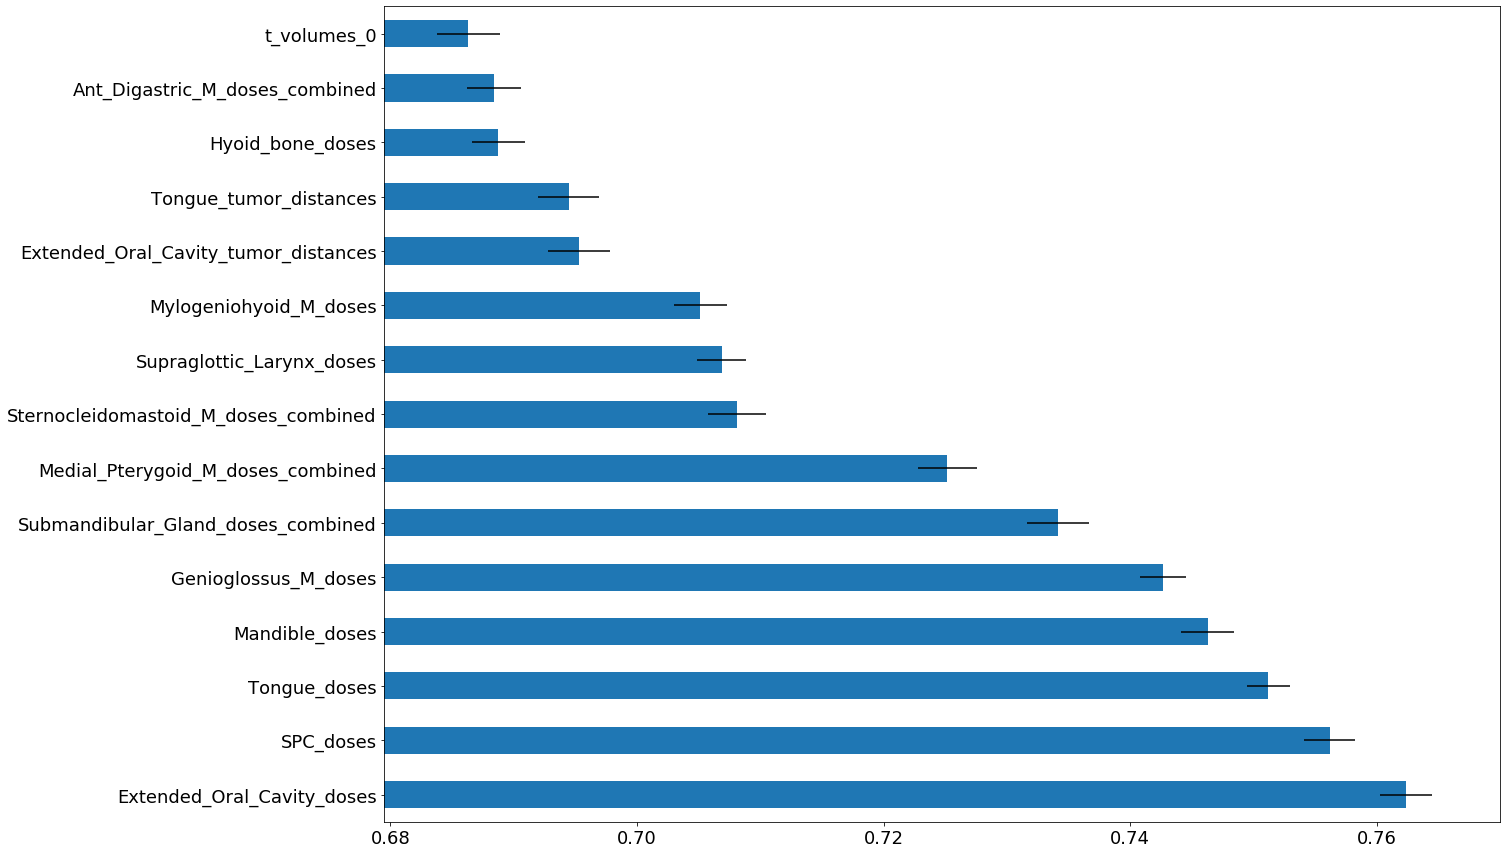

In [12]:
plot_n_importances(true_lg_importances, 15)